<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="../data/KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="../data/KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** 
- чем меньшего размера будут создаваться батчи, тем больше времени будет это занимать, т.к. модель учится на каждом батче, и мы сильнее будем отклоняться от минимума функции потерь
- чем большего размера будут создаваться батчи, тем меньше времени нужно будет модели, но тут все упирается в оперативку

Посмотрим на какую-нибудь картинку:

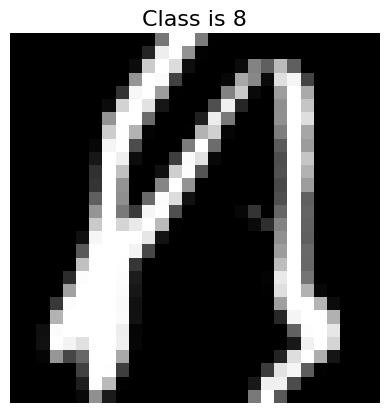

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [5]:
j = 0
images = []

for i, image in enumerate(trainset):
    if trainset[i][1] == j:
        images.append(image[0][0].view(28, 28).numpy())
        j += 1
        if j > 9:
            break

len(images)

10

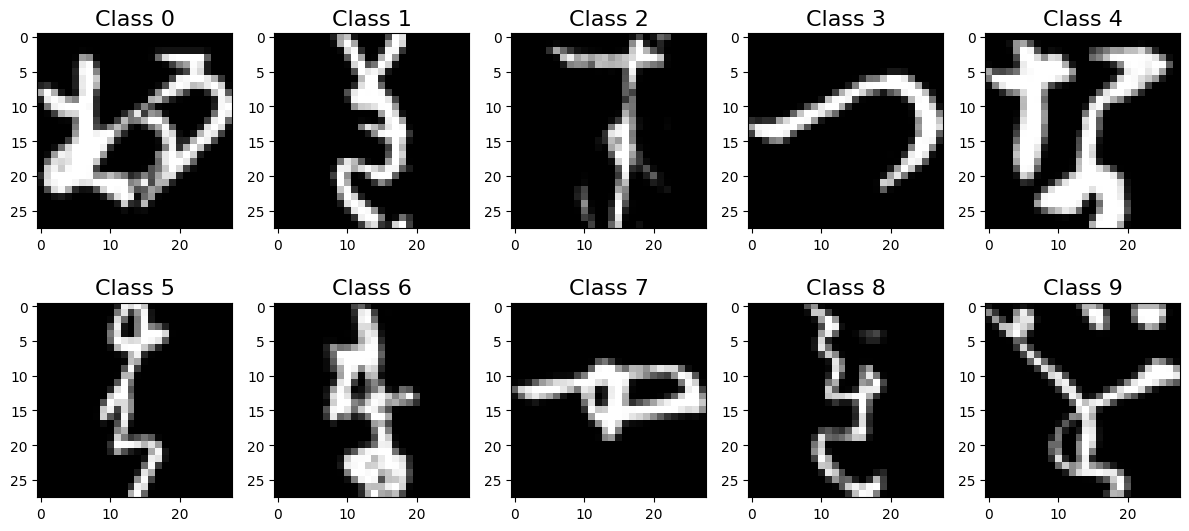

In [6]:
plt.figure(figsize=(12, 6))

for i, image in enumerate(images):
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Class {i}", fontsize=16)
    plt.tight_layout()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [7]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [8]:
print("Кол-во весов:", 28*28*256 + 256*128 + 128*10)
print("Кол-во смещений:", 256 + 128 + 10)

Кол-во весов: 234752
Кол-во смещений: 394


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [9]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [10]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

> Если в `optimizer` поставить `SGD` с `lr=0.001` (как на консультации), то `accuracy` 30% :(
>
> Оставлю `Adam`

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [11]:
%%time

n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.8967
Epoch=2 loss=0.4350
Epoch=3 loss=0.3449
Epoch=4 loss=0.2890
Epoch=5 loss=0.2488
Epoch=6 loss=0.2148
Epoch=7 loss=0.1877
Epoch=8 loss=0.1648
Epoch=9 loss=0.1446
Epoch=10 loss=0.1272
CPU times: user 2min 1s, sys: 1.04 s, total: 2min 2s
Wall time: 19.1 s


In [12]:
get_accuracy(fc_net, testloader)

0.8787

> Лучший скор, который удалось получить `0.8942` (несколько перезапусков, полный рандом)

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [13]:
length = len(trainloader)

means = [images.mean() for images, labels in trainloader]
mean = sum(means) / length ## calculate mean

stds = [images.std() for images, labels in trainloader]
std = sum(stds) / length ## calculate std

print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [14]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [15]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6872
Epoch=2 loss=0.3064
Epoch=3 loss=0.2254
Epoch=4 loss=0.1765
Epoch=5 loss=0.1406
Epoch=6 loss=0.1142
Epoch=7 loss=0.0945
Epoch=8 loss=0.0777
Epoch=9 loss=0.0631
Epoch=10 loss=0.0509


In [16]:
get_accuracy(fc_net, testloader)

0.8979

Как изменилась `accuracy` после нормализации?

> Даже несмотря на то, что в начале loss-функция была больше, чем в предыдущем примере (там прям нормально повезло), итоговая `accuracy` стала выше, т.е. нормализация данных помогла

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

> Апдейтнем класс для нашей NN

In [17]:
class FCNet(nn.Module):
    def __init__(self, activation=F.relu):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

In [18]:
n_epochs = 10
activation_funcs = [nn.Sigmoid(), nn.GELU(), nn.Tanh()]
accuracy_values = []

for activation in activation_funcs:
    fc_net = FCNet(activation=activation)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    
    print(f"Activation is {activation.__class__.__name__}")
    
    loss_history = []
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска
    
            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        if epoch+1 in [1, 5, 10]:
            print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    
    print(f"Accuracy: {get_accuracy(fc_net, testloader)}\n")
    accuracy_values.append(get_accuracy(fc_net, testloader))

Activation is Sigmoid
Epoch=1 loss=1.5552
Epoch=5 loss=0.3724
Epoch=10 loss=0.1862
Accuracy: 0.8562

Activation is GELU
Epoch=1 loss=0.6620
Epoch=5 loss=0.1247
Epoch=10 loss=0.0411
Accuracy: 0.9043

Activation is Tanh
Epoch=1 loss=0.7713
Epoch=5 loss=0.1363
Epoch=10 loss=0.0303
Accuracy: 0.8977



С использованием какой функции активации удалось досчить наибольшей `accuracy`?

> С помощью функции активации `nn.GELU()`

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [19]:
n_epochs = 10
optimizers = [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad]
accuracy_values = []

for optimizer in optimizers:
    fc_net = FCNet(activation=nn.GELU())
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer(fc_net.parameters(), lr=3e-4)
    
    print(f"Optimizer is {optimizer.__class__.__name__}")
    
    loss_history = []
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска
    
            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        if epoch+1 in [1, 5, 10]:
            print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    
    print(f"Accuracy: {get_accuracy(fc_net, testloader)}\n")
    accuracy_values.append(get_accuracy(fc_net, testloader))

Optimizer is Adam
Epoch=1 loss=0.6654
Epoch=5 loss=0.1200
Epoch=10 loss=0.0371
Accuracy: 0.9002

Optimizer is RMSprop
Epoch=1 loss=0.4397
Epoch=5 loss=0.1046
Epoch=10 loss=0.0307
Accuracy: 0.8929

Optimizer is Adagrad
Epoch=1 loss=1.3422
Epoch=5 loss=0.5807
Epoch=10 loss=0.4866
Accuracy: 0.725



> Лучше всего показал себя оптимизатор `Adam`

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [20]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [21]:
fc_net = FCNet(activation=CustomReLU())
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [22]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6849
Epoch=2 loss=0.3053
Epoch=3 loss=0.2240
Epoch=4 loss=0.1746
Epoch=5 loss=0.1383
Epoch=6 loss=0.1128
Epoch=7 loss=0.0919
Epoch=8 loss=0.0755
Epoch=9 loss=0.0612
Epoch=10 loss=0.0497


In [23]:
get_accuracy(fc_net, testloader)

0.8979

> Было `0.8942`, стало `0.8996`, зависит от рандома в батчах и кол-ва эпох, но в целом то же самое

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

У меня не запустился этот бот, поэтому я использовал вот этого https://t.me/gigachat_bot

![](data/kotik.jpg)

![](data/avocado.jpg)

![](data/sigma.jpg)